## Hands-on 08: Classificação de imagens (Flowers)

Baseado nesse artigo: https://towardsdatascience.com/flower-classification-with-convolutional-neural-networks-b97130329e5f

### Montando o drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Imports das bibliotecas

In [2]:
!pip install keras

In [3]:
import os
import cv2
import random
from os import listdir
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

### Caminho do dataset

In [4]:
path = '/content/gdrive/My Drive/Colab Notebooks/flowers'
categories = ['tulip', 'dandelion', 'daisy', 'rose', 'sunflower']

### Carregando o nome dos arquivos


In [5]:
fnames = []
for category in categories:
    flower_folder = os.path.join(path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print(f'Tamanho para cada categoria: {[len(f) for f in fnames]}')

Tamanho para cada categoria: [984, 1055, 769, 784, 734]


### Carregando os arquivos

In [6]:
images = []
for names in fnames:
    one_category_images = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    images.append(one_category_images)

print(f'Número de imagens para cada categoria: {[len(f) for f in fnames]}')

#### Salvando o array dos dados para economizar na memória

In [7]:
np.save('/content/gdrive/My Drive/Colab Notebooks/images', images)

#### Carrega os dados salvos

In [8]:
images_loaded = np.load('/content/gdrive/My Drive/Colab Notebooks/images.npy', allow_pickle=True)
print(f'Número de imagens para cada categoria: {[len(f) for f in fnames]}')

Número de imagens para cada categoria: [984, 1055, 769, 784, 734]


### Exemplo das imagens

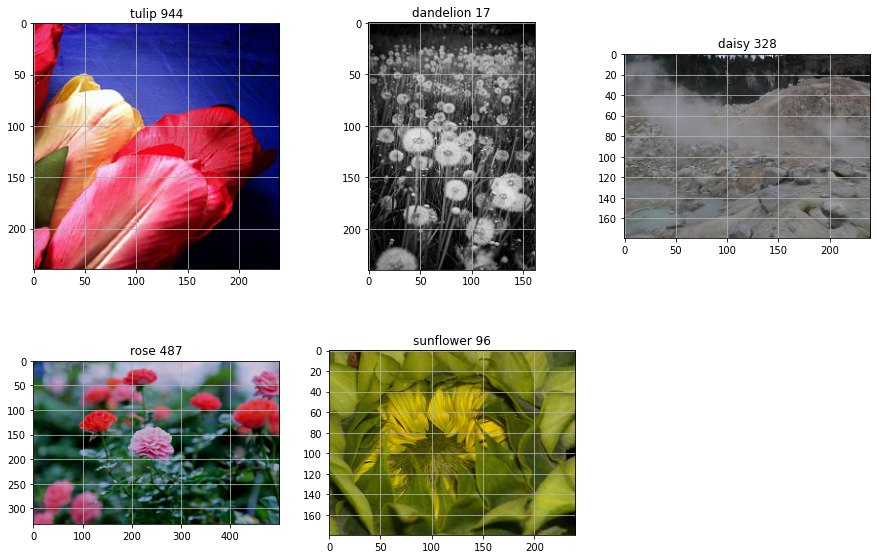

In [9]:
plt.figure(figsize=(15, 10))

for i, imgs in enumerate(images_loaded):
    plt.subplot(2, 3, i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(cv2.cvtColor(imgs[idx], cv2.COLOR_BGR2RGB))
    plt.grid('off')
    plt.title(categories[i]+' '+str(idx))
plt.show()

### Redimensionamento das imagens

In [10]:
resized_images = []
img_width, img_height = 144, 144

for i, imgs in enumerate(images_loaded):
    resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])

### Separação dos dados


In [11]:
from sklearn.model_selection import train_test_split

train_images = []
val_images = []

for imgs in resized_images:
    train, test = train_test_split(imgs, train_size=0.8, test_size=0.2)
    train_images.append(train)
    val_images.append(test)

### Gerando os rótulos

In [12]:
len_train_images = [len(imgs) for imgs in train_images]
print('Soma das imagens de treino:', np.sum(len_train_images))

train_categories = np.zeros((np.sum(len_train_images)), dtype='uint8')

for i in range(5):
    if i is 0:
        train_categories[:len_train_images[i]] = i
    else:
        train_categories[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i

Soma das imagens de treino: 3457


In [13]:
len_val_images = [len(imgs) for imgs in val_images]
print('Soma das imagens de teste:', np.sum(len_val_images))

val_categories = np.zeros((np.sum(len_val_images)), dtype='uint8')

for i in range(5):
    if i is 0:
        val_categories[:len_val_images[i]] = i
    else:
        val_categories[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i

Soma das imagens de teste: 866


### Converte os dados em matriz numpy

In [14]:
tmp_train_imgs = []
tmp_val_imgs = []

for imgs in train_images:
    tmp_train_imgs += imgs

for imgs in val_images:
    tmp_val_imgs += imgs
    
train_images = np.array(tmp_train_imgs)
val_images = np.array(tmp_val_imgs)

In [15]:
from tensorflow.python.keras.utils import np_utils

train_data = train_images.astype('float32')
train_labels = np_utils.to_categorical(train_categories, len(categories))

val_data = val_images.astype('float32')
val_labels = np_utils.to_categorical(val_categories, len(categories))

print(f'Train data: {train_data.shape}')
print(f'Train labels: {train_labels.shape}')

Train data: (3457, 144, 144, 3)
Train labels: (3457, 5)


### Embaralhando a base de dados

In [16]:
seed = 100
np.random.seed(seed)

np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(val_data)
np.random.seed(seed)
np.random.shuffle(val_labels)

X_train = train_data[:3400]
y_train = train_labels[:3400]
X_test = val_data[:860]
y_test = val_labels[:860]

### Normalização dos dados

In [17]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [18]:
X_train[0][0][:5]

array([[0.9098039 , 0.70980394, 0.58431375],
       [0.91764706, 0.7176471 , 0.5882353 ],
       [0.9254902 , 0.7294118 , 0.5882353 ],
       [0.92941177, 0.7254902 , 0.58431375],
       [0.92941177, 0.73333335, 0.5921569 ]], dtype=float32)

### Implementação da Rede

In [19]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential

In [45]:
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=train_data.shape[1:]))
model.add(Activation('relu'))
BatchNormalization(axis=1)
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
BatchNormalization(axis=1)
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
BatchNormalization(axis=1)
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
BatchNormalization()
model.add(Dense(512))
model.add(Activation('relu'))
BatchNormalization()
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 140, 140, 32)      2432      
_________________________________________________________________
activation_17 (Activation)   (None, 140, 140, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 138, 138, 32)      9248      
_________________________________________________________________
activation_18 (Activation)   (None, 138, 138, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 69, 69, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 67, 67, 64)        18496     
_________________________________________________________________
activation_19 (Activation)   (None, 67, 67, 64)       

In [46]:
model.compile(loss = 'categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

### Modelo

In [47]:
batch_size = 128
epochs = 50

In [48]:
import time

start = time.time()

model_cnn = model.fit(X_train, y_train,
                      batch_size= batch_size, 
                      epochs = epochs,
                      verbose = 1, 
                      validation_data=(X_test, y_test),
                      callbacks=[tbCallBack])

end = time.time()
print(f'Duração em minutos: {(end - start)/60}')

Epoch 1/50
27/27 [==============================] - 5s 190ms/step - loss: 1.4309 - accuracy: 0.3726 - val_loss: 1.2120 - val_accuracy: 0.4640
Epoch 2/50
27/27 [==============================] - 5s 184ms/step - loss: 1.1432 - accuracy: 0.5126 - val_loss: 1.1321 - val_accuracy: 0.4988
Epoch 3/50
27/27 [==============================] - 5s 187ms/step - loss: 1.0257 - accuracy: 0.5791 - val_loss: 1.0259 - val_accuracy: 0.5849
Epoch 4/50
27/27 [==============================] - 5s 190ms/step - loss: 0.9099 - accuracy: 0.6453 - val_loss: 0.9810 - val_accuracy: 0.6267
Epoch 5/50
27/27 [==============================] - 5s 191ms/step - loss: 0.7770 - accuracy: 0.7088 - val_loss: 1.0049 - val_accuracy: 0.6279
Epoch 6/50
27/27 [==============================] - 5s 192ms/step - loss: 0.6076 - accuracy: 0.7779 - val_loss: 0.9728 - val_accuracy: 0.6767
Epoch 7/50
27/27 [==============================] - 5s 195ms/step - loss: 0.4584 - accuracy: 0.8347 - val_loss: 1.1149 - val_accuracy: 0.6570
Epoch 

### Avaliação do modelo

In [49]:
score = model.evaluate(X_test, y_test, verbose=1)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

27/27 [==============================] - 0s 15ms/step - loss: 2.1512 - accuracy: 0.6523

Test score: 2.1512136459350586
Test accuracy: 0.6523255705833435


### Performance

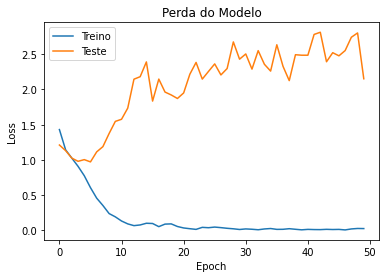

In [64]:
plt.plot(model_cnn.history['loss'])
plt.plot(model_cnn.history['val_loss'])
plt.title('Perda do Modelo')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Treino', 'Teste'], loc = 'upper left')
plt.show()

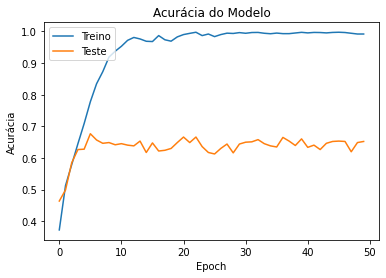

In [65]:
plt.plot(model_cnn.history['accuracy'])
plt.plot(model_cnn.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Epoch')
plt.legend(['Treino', 'Teste'], loc = 'upper left')
plt.show()

### Predição

In [80]:
pred = model.predict(X_test)

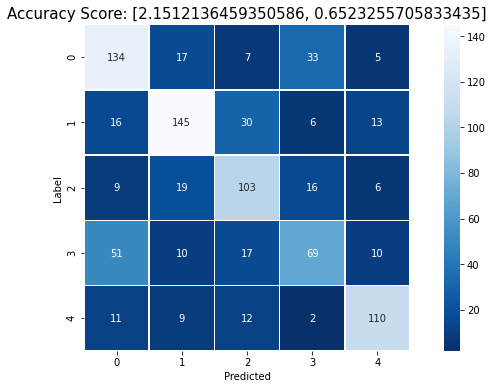

In [82]:
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Label');
plt.xlabel('Predicted');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### Salva o modelo

In [83]:
model.save('/content/gdrive/My Drive/Colab Notebooks/modelo_lab08.h5')

### Resultado

In [85]:
import pandas as pd

dic = {
    'EPOCH': [50, 50, 50, 50, 50, 50],
    'BATCH_SIZE': [128, 128, 128, 128, 128, 128],
    'DROPOUT': ['0.25 e 0.5', '0.25 e 0.5', '0.0 e 0.0', '0.0 e 0.5', '0.25 e 05', '0.25 e 0.5',],
    'ACTIVATION': ['relu e softmax', 'relu e softmax', 'relu e softmax', 'relu e softmax', 'relu e softmax', 'relu e softmax'],
    'BATCH NORMALIZATION': ['Não', 'Não', 'Não', 'Não', 'Não', 'Sim'],
    'DENSE' : [128, 512, 512, 512, 512, 512],
    'CAMADAS (Conv2D)': [2, 2, 2, 2, 4, 4],
    'ACCURACY': [0.576, 0.587, 0.581, 0.551, 0.647, 0.652]
}

res = pd.DataFrame(data=dic)
res.sort_values(['ACCURACY'], ascending=False)

,EPOCH,BATCH_SIZE,DROPOUT,ACTIVATION,BATCH NORMALIZATION,DENSE,CAMADAS (Conv2D),ACCURACY
5,50,128,0.25 e 0.5,relu e softmax,Sim,512,4,0.652
4,50,128,0.25 e 05,relu e softmax,Não,512,4,0.647
1,50,128,0.25 e 0.5,relu e softmax,Não,512,2,0.587
2,50,128,0.0 e 0.0,relu e softmax,Não,512,2,0.581
0,50,128,0.25 e 0.5,relu e softmax,Não,128,2,0.576
3,50,128,0.0 e 0.5,relu e softmax,Não,512,2,0.551
